### Курсовая по алгоритмам

#### Tutors - expected math exam results
#### Predict average math exam results for students of the tutors

### на Кагле я Sergey Solovyev

In [2]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import model_selection
import numpy as np
from tqdm import tqdm
import random
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [3]:
df_train = pd.read_csv('train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [5]:
TARGET_NAME = 'mean_exam_points'
FEATURE_NAMES = ['age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'chemistry', 'biology', 'english', 'geography', 'history']

In [6]:
# Теперь приведём наши данные к формату np.array
X = df_train[FEATURE_NAMES].values
y = df_train[TARGET_NAME].values

print(X.shape, y.shape)

(10000, 10) (10000,)


In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [8]:
def gb_predict_(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    for x in X:
        sum = 0
        for alg, coef, eta in zip(trees_list, coef_list, eta):
            sum += eta * coef * alg.predict([x])[0]
            print(eta, coef, alg.predict([x])[0])
            
    return np.array(sum)

In [9]:
def gb_predict(X, trees_list, coef_list, eta_list):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta * coef * alg.predict([x])[0] for alg, coef, eta in zip(trees_list, coef_list, eta_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [10]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [11]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [12]:
def sigmoid(alpha, x):
    return 1 / ( 1 + np.exp(- alpha * x) )

In [13]:
def evaluate_alg(max_depth, X_train, X_test, y_train, y_test, trees, coefs, eta_list):
    train_prediction = gb_predict(X_train, trees, coefs, eta_list)

    print(f'Ошибка алгоритма из {len(trees)} деревьев глубиной {max_depth} \
    на тренировочной выборке: {r_2(y_train, train_prediction)} / {r2_score(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta_list)

    print(f'Ошибка алгоритма из {len(trees)} деревьев глубиной {max_depth} \
    на тестовой выборке: {r_2(y_test, test_prediction)} / {r2_score(y_test, test_prediction)}')

In [14]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('R2')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [15]:
def r_2(y_true, y_pred):
    numerator = ((y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    denominator = ((y_true - np.average(y_true)) ** 2).sum(axis=0, dtype=np.float64)
    return 1 - (numerator / denominator)

In [16]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, a, b):
    
    # Деревья будем записывать в список
    trees = []
    eta_list = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in tqdm(range(n_trees)):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            eta_list.append(eta)
        
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            y_train_pred = gb_predict(X_train, trees, coefs, eta_list)
            y_test_pred = gb_predict(X_test, trees, coefs, eta_list)
            prev_err = mean_squared_error(y_train, y_train_pred)
            train_errors.append(prev_err)
            test_errors.append(mean_squared_error(y_test, y_test_pred))
            
            train_r2_score = r2_score(y_train, y_train_pred)
            test_r2_score = r2_score(y_test, y_test_pred)
            
            print(i, eta, prev_err, train_r2_score, test_r2_score)
            eta_list.append(eta)
#             eta = np.log(prev_err)/ (2 * a)
#             eta = eta_calc(eta, prev_err-1, prev_err)
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta_list)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            y_train_pred = gb_predict(X_train, trees, coefs, eta_list)
            y_test_pred = gb_predict(X_test, trees, coefs, eta_list)
            curr_err = mean_squared_error(y_train, y_train_pred)
            train_errors.append(curr_err)
            test_errors.append(mean_squared_error(y_test, y_test_pred))
            
            train_r2_score = r2_score(y_train, y_train_pred)
            test_r2_score = r2_score(y_test, y_test_pred)
        
            print(i, eta, curr_err, train_r2_score, test_r2_score) 
#             eta = np.log(curr_err)/a
#             eta = eta_calc(eta, curr_err, prev_err)
            eta_list.append(eta)
            prev_err = curr_err

        trees.append(tree)
#         max_depth += 1
        
    return trees, train_errors, test_errors, eta_list

In [18]:
def eta_calc(eta, curr_err, prev_err):
    if curr_err > prev_err:
        return eta * 2
    else:
        return eta / 2
    

  0%|          | 0/50 [00:00<?, ?it/s]

0 0.3 4320.684 -22.40793080219036 -23.16819592263948


  4%|▍         | 2/50 [00:01<00:27,  1.75it/s]

1 0.3 2140.900558441586 -10.598638578144437 -10.958073595490756


  6%|▌         | 3/50 [00:03<00:48,  1.03s/it]

2 0.3 1073.2798607857615 -4.814648956659986 -4.978367486592611


  8%|▊         | 4/50 [00:06<01:14,  1.61s/it]

3 0.3 548.764197088983 -1.9730094476195226 -2.047493827027247


 10%|█         | 5/50 [00:10<01:44,  2.31s/it]

4 0.3 291.892841864551 -0.5813717096691471 -0.6107974989322802


 12%|█▏        | 6/50 [00:15<02:15,  3.08s/it]

5 0.3 165.27076411270147 0.10462171962234401 0.09641485270389827


 14%|█▍        | 7/50 [00:20<02:48,  3.92s/it]

6 0.3 103.227199279259 0.440751710230875 0.4399919637993721


 16%|█▌        | 8/50 [00:27<03:19,  4.76s/it]

7 0.3 72.46950233937987 0.607385984249399 0.6091419926781676


 18%|█▊        | 9/50 [00:35<03:52,  5.66s/it]

8 0.3 57.29113263125217 0.6896169985559092 0.69139973679024


 20%|██        | 10/50 [00:44<04:23,  6.58s/it]

9 0.3 48.98466718090171 0.7346184771348978 0.7363368766456413


 22%|██▏       | 11/50 [00:53<04:51,  7.47s/it]

10 0.3 45.171898473347454 0.755274703341487 0.7567015349203984


 24%|██▍       | 12/50 [01:04<05:20,  8.45s/it]

11 0.3 42.42738770787792 0.7701434875626852 0.772210127202748


 26%|██▌       | 13/50 [01:15<05:45,  9.33s/it]

12 0.3 41.36870112037301 0.7758790753496009 0.7770241347813858


 28%|██▊       | 14/50 [01:28<06:09, 10.25s/it]

13 0.3 40.472719807680726 0.7807331837656664 0.7808888568425112


 30%|███       | 15/50 [01:42<06:36, 11.34s/it]

14 0.3 40.04800349972667 0.7830341458233279 0.7818195589667727


 32%|███▏      | 16/50 [01:56<06:57, 12.28s/it]

15 0.3 39.715379037952204 0.7848361869780012 0.7828655288561001


 34%|███▍      | 17/50 [02:12<07:21, 13.39s/it]

16 0.3 39.55713704631834 0.7856934858663635 0.7828250347903438


 36%|███▌      | 18/50 [02:30<07:51, 14.74s/it]

17 0.3 39.236505761414925 0.7874305522498436 0.7831064558366087


 38%|███▊      | 19/50 [02:49<08:15, 16.00s/it]

18 0.3 39.11069683549385 0.7881121403114224 0.7831396779359837


 40%|████      | 20/50 [03:08<08:28, 16.93s/it]

19 0.3 38.90514879581025 0.789225726560599 0.7840876571721521


 42%|████▏     | 21/50 [03:28<08:35, 17.78s/it]

20 0.3 38.822381200322035 0.7896741319861875 0.7839185708291452


 44%|████▍     | 22/50 [03:50<08:52, 19.02s/it]

21 0.3 38.60571263500325 0.790847965292208 0.7844510310734832


 46%|████▌     | 23/50 [04:14<09:15, 20.59s/it]

22 0.3 38.52559035576598 0.7912820393342124 0.7844020062423273


 48%|████▊     | 24/50 [04:39<09:29, 21.90s/it]

23 0.3 38.44728064214941 0.7917062935396737 0.7842881390111356


 50%|█████     | 25/50 [05:04<09:34, 23.00s/it]

24 0.3 38.37154267611444 0.792116614930465 0.7839400335540769


 52%|█████▏    | 26/50 [05:30<09:30, 23.77s/it]

25 0.3 38.182995633569064 0.7931380958174856 0.783990970497062


 54%|█████▍    | 27/50 [05:57<09:30, 24.78s/it]

26 0.3 38.10132565745126 0.7935805547313018 0.7842175167639314


 56%|█████▌    | 28/50 [06:24<09:22, 25.55s/it]

27 0.3 38.02070138757457 0.7940173483802355 0.7841699854045777


 58%|█████▊    | 29/50 [06:52<09:07, 26.08s/it]

28 0.3 37.93629682569047 0.7944746223081542 0.7839602879478458


 60%|██████    | 30/50 [07:20<08:54, 26.72s/it]

29 0.3 37.892473371220326 0.7947120422142959 0.7839441605009764


 62%|██████▏   | 31/50 [07:51<08:53, 28.10s/it]

30 0.3 37.849141420114854 0.7949467993298365 0.7840108605229856


 64%|██████▍   | 32/50 [08:24<08:53, 29.63s/it]

31 0.3 37.692451260671454 0.7957956909427467 0.7845440666523198


 66%|██████▌   | 33/50 [08:56<08:35, 30.31s/it]

32 0.3 37.45413810867599 0.7970867869292059 0.7851778517427281


 68%|██████▊   | 34/50 [09:28<08:11, 30.71s/it]

33 0.3 37.3609469144664 0.7975916637092326 0.78533791224747


 70%|███████   | 35/50 [10:04<08:06, 32.43s/it]

34 0.3 37.35214574112058 0.7976393453394238 0.7853409831225733


 72%|███████▏  | 36/50 [10:42<07:57, 34.07s/it]

35 0.3 37.27254249215455 0.7980706074598245 0.7853583804638606


 74%|███████▍  | 37/50 [11:21<07:39, 35.34s/it]

36 0.3 37.21472074533414 0.798383865140422 0.7851506661242964


 76%|███████▌  | 38/50 [12:01<07:20, 36.72s/it]

37 0.3 37.14782725032209 0.7987462703295902 0.7853447623651996


 78%|███████▊  | 39/50 [12:40<06:51, 37.45s/it]

38 0.3 37.097202577674395 0.7990205368193919 0.785190440322204


 80%|████████  | 40/50 [13:18<06:16, 37.62s/it]

39 0.3 37.07591364977874 0.7991358726669191 0.7852274207809944


 82%|████████▏ | 41/50 [13:59<05:48, 38.75s/it]

40 0.3 37.01522823287519 0.7994646446945842 0.7850812055016779


 84%|████████▍ | 42/50 [14:45<05:27, 40.90s/it]

41 0.3 36.931437204498486 0.7999185947159437 0.7850162660699384


 86%|████████▌ | 43/50 [15:29<04:51, 41.66s/it]

42 0.3 36.92431209203708 0.799957196043755 0.7850279926981337


 88%|████████▊ | 44/50 [16:10<04:10, 41.67s/it]

43 0.3 36.853726150120664 0.8003396055983499 0.7848804462953836


 90%|█████████ | 45/50 [16:54<03:31, 42.26s/it]

44 0.3 36.70365570761214 0.8011526339368484 0.7853996865038242


 92%|█████████▏| 46/50 [17:38<02:51, 42.85s/it]

45 0.3 36.62288061174999 0.8015902447073836 0.7853865657418957


 94%|█████████▍| 47/50 [18:23<02:10, 43.45s/it]

46 0.3 36.533161175704876 0.8020763127351674 0.7852872693487194


 96%|█████████▌| 48/50 [19:10<01:28, 44.42s/it]

47 0.3 36.40225519407969 0.8027855148336018 0.7858093243818821


 98%|█████████▊| 49/50 [19:57<00:45, 45.20s/it]

48 0.3 36.32048277020067 0.8032285287729903 0.7860408968605554


100%|██████████| 50/50 [20:45<00:00, 24.91s/it]

49 0.3 36.23151283613718 0.8037105362653293 0.7859686553042409


Ошибка алгоритма из 50 деревьев глубиной 4     на тренировочной выборке: 0.8039905047830549 / 0.8039905047830549
Ошибка алгоритма из 50 деревьев глубиной 4     на тестовой выборке: 0.7857253853731645 / 0.7857253853731645


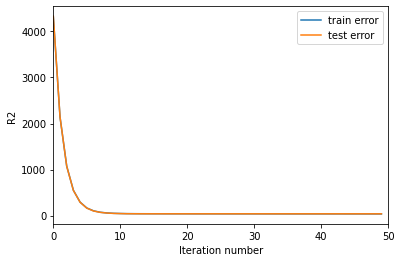

In [19]:
n_trees_max = 50
max_depth = 4
eta = 0.3
a = 12
b = n_trees_max * 3
coefs = [1] * n_trees_max
trees, train_errors, test_errors, eta_list = gb_fit(n_trees_max, max_depth, X_train, X_test, y_train, y_test, coefs, eta, a, b)
evaluate_alg(max_depth, X_train, X_test, y_train, y_test, trees, coefs, eta_list)
get_error_plot(n_trees_max, train_errors, test_errors)

In [20]:
df_test = pd.read_csv('test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 859.5 KB


In [21]:
# Теперь приведём наши данные к формату np.array
XT = df_test[FEATURE_NAMES].values

print(XT.shape)

(10000, 10)


In [22]:
test_pred = gb_predict(XT, trees, coefs, eta_list)

In [23]:
submissions = pd.concat([df_test['Id'], pd.Series(test_pred)], axis=1)
submissions = submissions.rename(columns={0: 'mean_exam_points'})

In [24]:
submissions.to_csv('SS10.csv',index=None)